In [1]:
from os import path

import sys
sys.path.append(path.join("..", "notebooks"))
sys.path.append(path.join("..", "notebooks", "utils.py"))
import utils

from openTSNE import TSNE, TSNEEmbedding
from openTSNE import affinity
from openTSNE import initialization
from openTSNE.callbacks import ErrorLogger

import numpy as np
import pandas as pd
import scipy.sparse as sp

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import anndata
import scanpy as sc

In [3]:
adata = anndata.read_h5ad(path.join("..", "data", "hrvatin_2018.h5ad"))
sc.pp.filter_genes(adata, min_counts=1)
adata

AnnData object with n_obs × n_vars = 48266 × 20394 
    obs: 'labels', 'batch_id', 'paper_cell_type', 'paper_cell_subtype'
    var: 'n_counts'
    uns: 'name', 'organism', 'tissue', 'year'

In [4]:
adata.obs["labels"].value_counts()

Neuron              15223
Microglia           10158
Oligodendrocyte      8630
Astrocyte            7039
Endothelial cell     3450
OPC                  1826
Pericyte              782
Muscle cell           621
Macrophage            537
Name: labels, dtype: int64

Chosen offset: 0.34
Chosen offset: 1.21


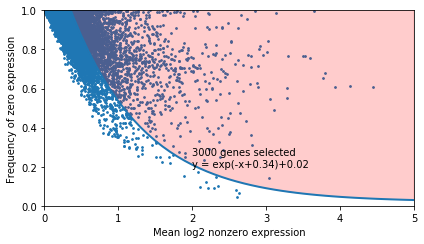

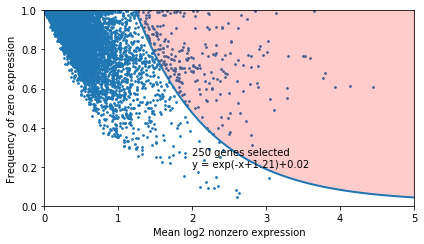

In [5]:
gene_mask_3000 = utils.select_genes(adata.X, n=3000, threshold=0)
gene_mask_250 = utils.select_genes(adata.X, n=250, threshold=0)

In [6]:
adata_norm = adata.copy()
sc.pp.normalize_per_cell(adata_norm, counts_per_cell_after=1_000_000)
sc.pp.log1p(adata_norm)

In [7]:
adata_norm.X = adata_norm.X.toarray()
adata_norm.X -= adata_norm.X.mean(axis=0)
adata_norm.X /= adata_norm.X.std(axis=0)

In [8]:
adata_250 = adata_norm[:, gene_mask_250].copy()
adata_3000 = adata_norm[:, gene_mask_3000].copy()
adata_full = adata_norm

In [9]:
%%time
for adata_ in [adata_250, adata_3000, adata_full]:
    print("Computing PCA for %d genes" % adata_.shape[1])
    U, S, V = np.linalg.svd(adata_.X, full_matrices=False)
    U[:, np.sum(V, axis=1) < 0] *= -1
    adata_.obsm["pca"] = np.dot(U, np.diag(S))
    adata_.obsm["pca"] = adata_.obsm["pca"][:, np.argsort(S)[::-1]][:, :50]

Computing PCA for 250 genes
Computing PCA for 3000 genes
Computing PCA for 20394 genes
CPU times: user 13h 43min 50s, sys: 11min 38s, total: 13h 55min 28s
Wall time: 26min 30s
Compiler : 5.21 s
Parser   : 152 ms


## Run t-SNE

In [10]:
%%time
for adata_ in [adata_250, adata_3000, adata_full]:
    print("Computing t-SNE for %d genes" % adata_.shape[1])
    affinities = affinity.Multiscale(
        adata_.obsm["pca"],
        perplexities=[50, 500],
        metric="cosine",
        n_jobs=8,
        random_state=3,
    )
    init = initialization.pca(adata_.obsm["pca"], random_state=42)
    embedding = TSNEEmbedding(
        init,
        affinities,
        negative_gradient_method="fft",
        n_jobs=8,
    )
    embedding.optimize(n_iter=250, exaggeration=12, momentum=0.5, inplace=True)
    embedding.optimize(n_iter=750, exaggeration=1, momentum=0.8, inplace=True)
    
    adata_.obsm["tsne"] = embedding

Computing t-SNE for 250 genes
Computing t-SNE for 3000 genes
Computing t-SNE for 20394 genes
CPU times: user 7h 58min 42s, sys: 1min 11s, total: 7h 59min 54s
Wall time: 23min 28s


In [11]:
adata_250.write_h5ad("hrvatin_embedding_tsne_250_genes.h5ad")
adata_3000.write_h5ad("hrvatin_embedding_tsne_3000_genes.h5ad")
adata_full.write_h5ad("hrvatin_embedding_tsne_all_genes.h5ad")

In [12]:
adata_250 = anndata.read_h5ad("hrvatin_embedding_tsne_250_genes.h5ad")
adata_3000 = anndata.read_h5ad("hrvatin_embedding_tsne_3000_genes.h5ad")
adata_full = anndata.read_h5ad("hrvatin_embedding_tsne_all_genes.h5ad")

In [15]:
colors = utils.get_colors_for(adata)

In [13]:
legend_kwargs = dict(loc="center", bbox_to_anchor=(0.5, -0.05), ncol=len(np.unique(adata.obs["labels"])))

Text(0, 1.02, 'c')

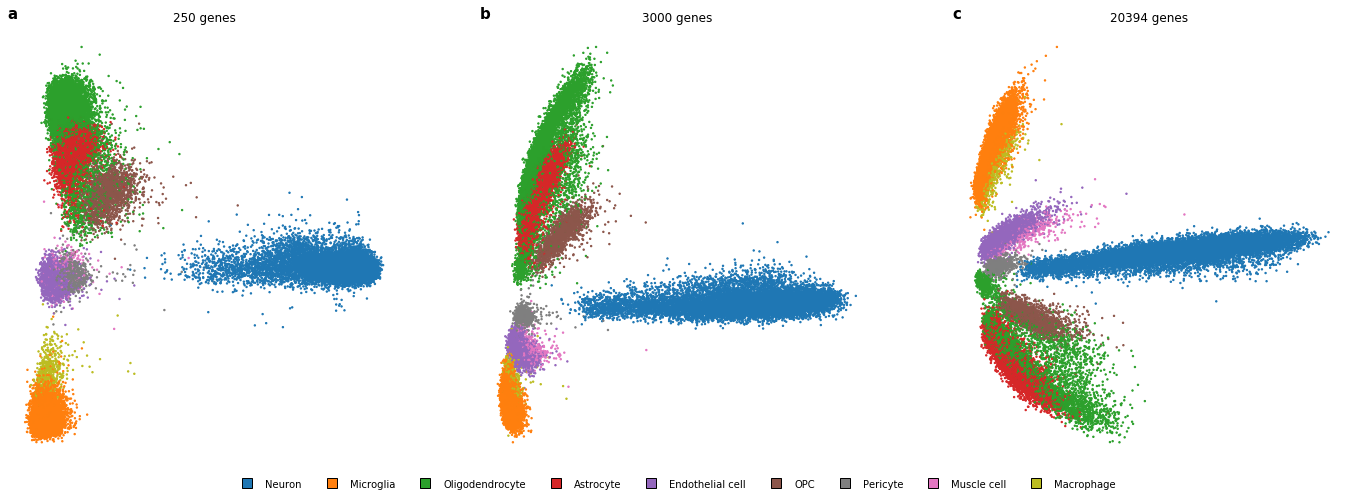

In [16]:
fig, ax = plt.subplots(ncols=3, figsize=(24, 8))

utils.plot(adata_250.obsm["pca"], adata.obs["labels"],  s=2, colors=colors, draw_legend=False, ax=ax[0], alpha=1, title="250 genes", label_order=list(colors.keys()))
utils.plot(adata_3000.obsm["pca"], adata.obs["labels"], s=2, colors=colors, draw_legend=True, ax=ax[1], alpha=1, title="3000 genes", label_order=list(colors.keys()),
          legend_kwargs=legend_kwargs)
utils.plot(adata_full.obsm["pca"], adata.obs["labels"], s=2, colors=colors, draw_legend=False, ax=ax[2], alpha=1, title="20394 genes", label_order=list(colors.keys()))

plt.text(0, 1.02, "a", transform=ax[0].transAxes, fontsize=15, fontweight="bold")
plt.text(0, 1.02, "b", transform=ax[1].transAxes, fontsize=15, fontweight="bold")
plt.text(0, 1.02, "c", transform=ax[2].transAxes, fontsize=15, fontweight="bold")

Text(0, 1.02, 'c')

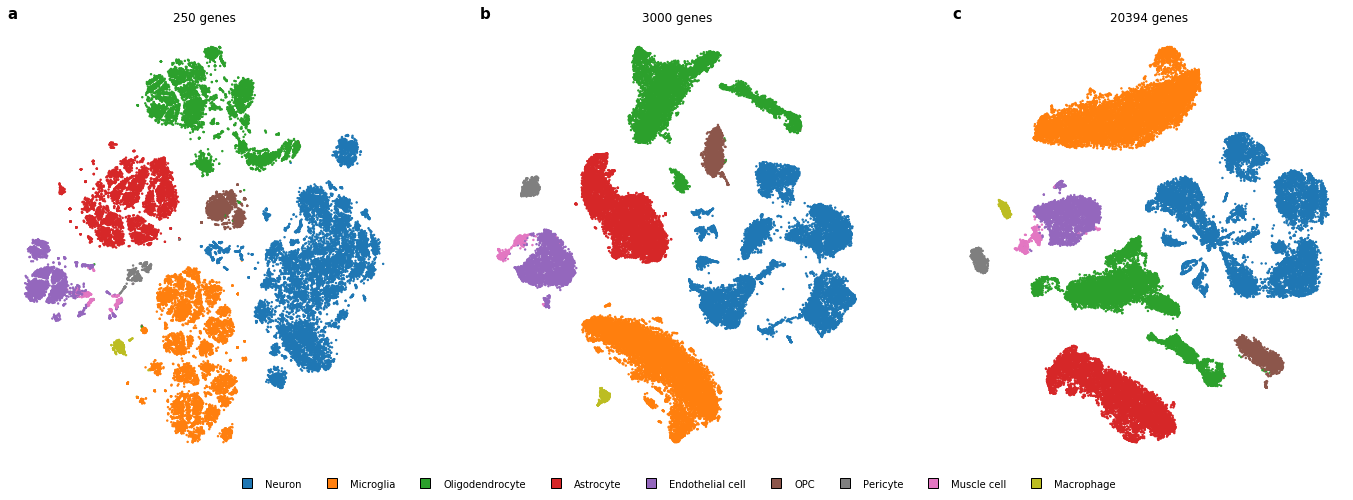

In [17]:
fig, ax = plt.subplots(ncols=3, figsize=(24, 8))

utils.plot(adata_250.obsm["tsne"],  adata.obs["labels"], s=2, colors=colors, draw_legend=False, ax=ax[0], alpha=1, title="250 genes", label_order=list(colors.keys()))
utils.plot(adata_3000.obsm["tsne"], adata.obs["labels"], s=2, colors=colors, draw_legend=True, ax=ax[1], alpha=1, title="3000 genes", label_order=list(colors.keys()),
           legend_kwargs=legend_kwargs)
utils.plot(adata_full.obsm["tsne"], adata.obs["labels"], s=2, colors=colors, draw_legend=False, ax=ax[2], alpha=1, title="20394 genes", label_order=list(colors.keys()))

plt.text(0, 1.02, "a", transform=ax[0].transAxes, fontsize=15, fontweight="bold")
plt.text(0, 1.02, "b", transform=ax[1].transAxes, fontsize=15, fontweight="bold")
plt.text(0, 1.02, "c", transform=ax[2].transAxes, fontsize=15, fontweight="bold")

## Transform

In [18]:
new = anndata.read_h5ad(path.join("..", "data", "chen_2017.h5ad"))

In [19]:
new.obs["labels"].value_counts()

Oligodendrocyte    3541
unknown            2531
Neuron             2315
OPC                1792
epithelial cell    1197
Astrocyte          1148
Microglia           724
tanycyte            609
ependymal cell      413
Macrophage          167
Name: labels, dtype: int64

In [20]:
cell_mask = new.obs["labels"].isin(adata.obs["labels"])
cell_mask.sum()

9687

In [21]:
new = new[cell_mask].copy()

In [22]:
shared_genes = adata.var_names[adata.var_names.isin(new.var_names)]
shared_genes

Index(['0610007P14RIK', '0610009B22RIK', '0610009L18RIK', '0610009O20RIK',
       '0610010F05RIK', '0610010K14RIK', '0610011F06RIK', '0610012G03RIK',
       '0610030E20RIK', '0610031O16RIK',
       ...
       'ZUFSP', 'ZW10', 'ZWILCH', 'ZWINT', 'ZXDB', 'ZXDC', 'ZYG11B', 'ZYX',
       'ZZEF1', 'ZZZ3'],
      dtype='object', name='index', length=16628)

In [23]:
adata = adata[:, adata.var_names.isin(shared_genes)]
new = new[:, new.var_names.isin(shared_genes)]

In [24]:
adata = adata[:, adata.var_names.argsort()].copy()
new = new[:, new.var_names.argsort()].copy()
assert all(adata.var_names == new.var_names)

Chosen offset: 1.19
Chosen offset: 0.58
Chosen offset: 0.24


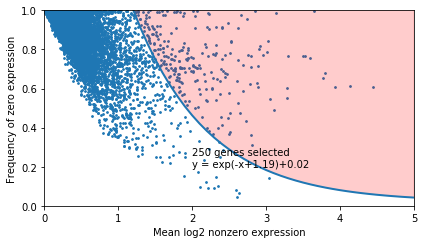

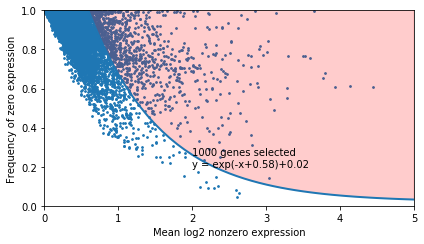

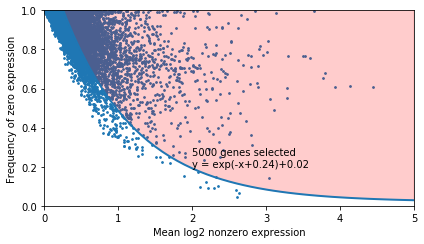

In [25]:
gene_mask_250 = utils.select_genes(adata.X, n=250, threshold=0)
gene_mask_1000 = utils.select_genes(adata.X, n=1000, threshold=0)
gene_mask_5000 = utils.select_genes(adata.X, n=5000, threshold=0)

In [26]:
adata_250 = adata[:, gene_mask_250].copy()
adata_1000 = adata[:, gene_mask_1000].copy()
adata_5000 = adata[:, gene_mask_5000].copy()

new_250 = new[:, gene_mask_250].copy()
new_1000 = new[:, gene_mask_1000].copy()
new_5000 = new[:, gene_mask_5000].copy()

In [32]:
%%time
affinity_obs = {}
for adata_, new_ in [(adata_250, new_250), (adata_1000, new_1000), (adata_5000, new_5000)]:
    print("Running transform for %d genes" % adata_.shape[1])
    affinities = affinity.PerplexityBasedNN(
        adata_.X.toarray() if sp.issparse(adata_.X) else adata_.X,
        perplexity=30,
        metric="cosine",
        n_jobs=8,
        random_state=3,
    )
    affinity_obs[adata_.shape[1]] = affinities
    embedding = TSNEEmbedding(
        adata_3000.obsm["tsne"],
        affinities,
        negative_gradient_method="fft",
        n_jobs=8,
        callbacks=[ErrorLogger()],
    )
    new_embedding = embedding.prepare_partial(new_.X.toarray(), k=10)
    new_.obsm["tsne_init"] = new_embedding.copy()
    
    new_embedding.optimize(250, learning_rate=0.1, momentum=0.8, inplace=True)
    new_.obsm["tsne"] = new_embedding

Running transform for 250 genes
Iteration   50, KL divergence  137549.8099, 50 iterations in 2.8100 sec
Iteration  100, KL divergence  137459.2211, 50 iterations in 3.3466 sec
Iteration  150, KL divergence  137446.7640, 50 iterations in 2.9541 sec
Iteration  200, KL divergence  137443.8721, 50 iterations in 2.9020 sec
Iteration  250, KL divergence  137443.5657, 50 iterations in 3.1131 sec
Running transform for 1000 genes
Iteration   50, KL divergence  135026.0837, 50 iterations in 2.8380 sec
Iteration  100, KL divergence  134921.6526, 50 iterations in 2.7903 sec
Iteration  150, KL divergence  134906.0245, 50 iterations in 3.1456 sec
Iteration  200, KL divergence  134902.9430, 50 iterations in 2.4178 sec
Iteration  250, KL divergence  134903.6265, 50 iterations in 3.2014 sec
Running transform for 5000 genes
Iteration   50, KL divergence  133210.4040, 50 iterations in 2.5626 sec
Iteration  100, KL divergence  133114.9170, 50 iterations in 2.3505 sec
Iteration  150, KL divergence  133103.

In [33]:
new_250.write_h5ad("hrvatin_transform_tsne_250_genes.h5ad")
new_1000.write_h5ad("hrvatin_transform_tsne_1000_genes.h5ad")
new_5000.write_h5ad("hrvatin_transform_tsne_5000_genes.h5ad")

In [34]:
new_250 = anndata.read_h5ad("hrvatin_transform_tsne_250_genes.h5ad")
new_1000 = anndata.read_h5ad("hrvatin_transform_tsne_1000_genes.h5ad")
new_5000 = anndata.read_h5ad("hrvatin_transform_tsne_5000_genes.h5ad")

In [35]:
new_5000.shape

(9687, 5000)

Text(0, 1.02, 'c')

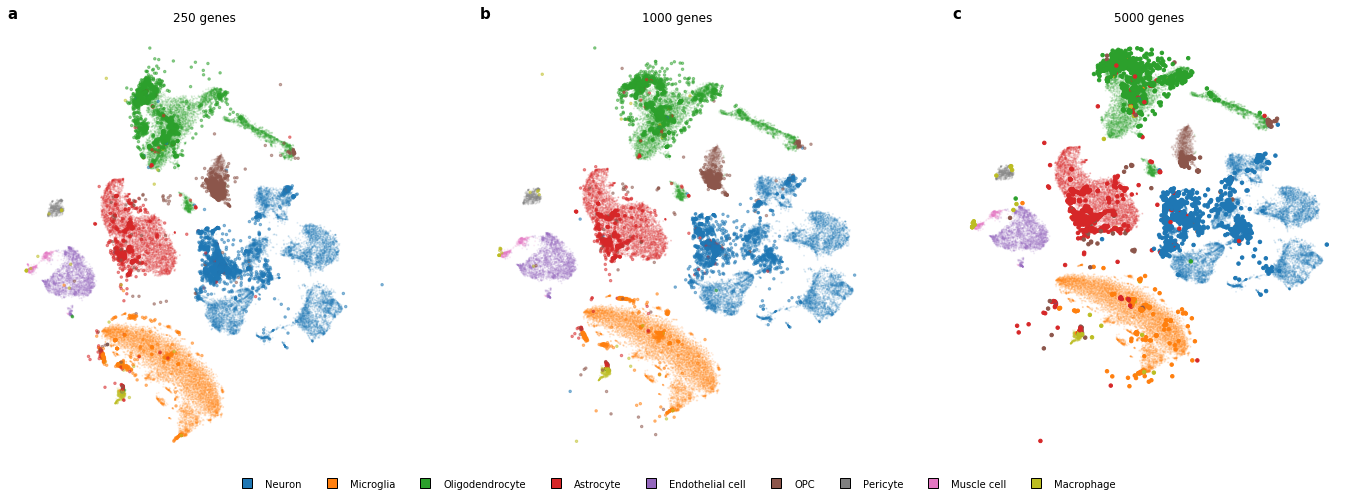

In [36]:
fig, ax = plt.subplots(ncols=3, figsize=(24, 8))

utils.plot(adata_3000.obsm["tsne"], adata.obs["labels"], s=1, colors=colors, draw_legend=False, ax=ax[0], alpha=0.1, title="250 genes", label_order=list(colors.keys()))
utils.plot(new_250.obsm["tsne"], new.obs["labels"], s=6, colors=colors, draw_legend=False, ax=ax[0], alpha=0.5, label_order=list(colors.keys()))

utils.plot(adata_3000.obsm["tsne"], adata.obs["labels"], s=1, colors=colors, draw_legend=True, ax=ax[1], alpha=0.1, title="1000 genes", label_order=list(colors.keys()),
          legend_kwargs=legend_kwargs)
utils.plot(new_1000.obsm["tsne"], new.obs["labels"], s=6, colors=colors, draw_legend=False, ax=ax[1], alpha=0.5, label_order=list(colors.keys()))

utils.plot(adata_3000.obsm["tsne"], adata.obs["labels"], s=1, colors=colors, draw_legend=False, ax=ax[2], alpha=0.1, title="5000 genes", label_order=list(colors.keys()))
utils.plot(new_5000.obsm["tsne"], new.obs["labels"], s=12, colors=colors, draw_legend=False, ax=ax[2], alpha=1, label_order=list(colors.keys()))

plt.text(0, 1.02, "a", transform=ax[0].transAxes, fontsize=15, fontweight="bold")
plt.text(0, 1.02, "b", transform=ax[1].transAxes, fontsize=15, fontweight="bold")
plt.text(0, 1.02, "c", transform=ax[2].transAxes, fontsize=15, fontweight="bold")

Text(0, 1.02, 'd')

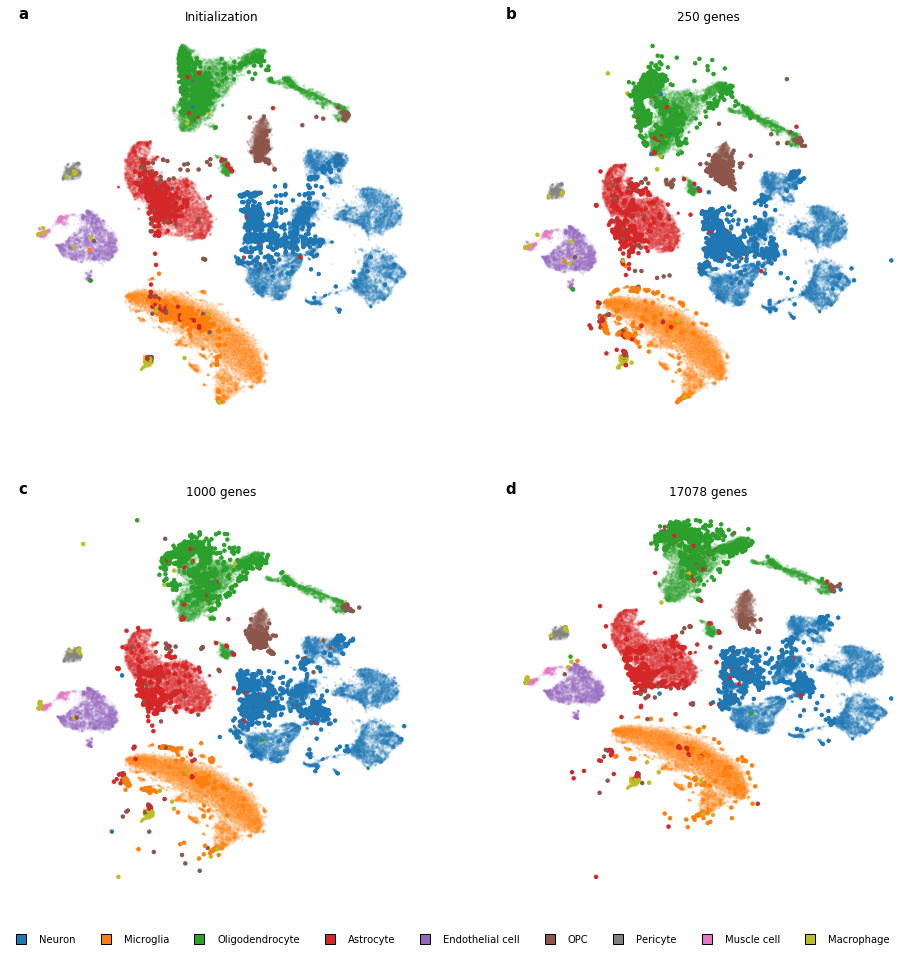

In [38]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 16))

utils.plot(adata_3000.obsm["tsne"], adata.obs["labels"], s=3, colors=colors, draw_legend=False, ax=ax[0, 0], alpha=0.1, title="Initialization", label_order=list(colors.keys()))
utils.plot(new_250.obsm["tsne_init"], new.obs["labels"], s=12, colors=colors, draw_legend=False, ax=ax[0, 0], alpha=1, label_order=list(colors.keys()))

utils.plot(adata_3000.obsm["tsne"], adata.obs["labels"], s=3, colors=colors, draw_legend=False, ax=ax[0, 1], alpha=0.1, title="250 genes", label_order=list(colors.keys()))
utils.plot(new_250.obsm["tsne"], new.obs["labels"], s=12, colors=colors, draw_legend=False, ax=ax[0, 1], alpha=1, label_order=list(colors.keys()))

utils.plot(adata_3000.obsm["tsne"], adata.obs["labels"], s=3, colors=colors, draw_legend=False, ax=ax[1, 0], alpha=0.1, title="1000 genes", label_order=list(colors.keys()))
utils.plot(new_1000.obsm["tsne"], new.obs["labels"], s=12, colors=colors, draw_legend=False, ax=ax[1, 0], alpha=1, label_order=list(colors.keys()))

utils.plot(adata_3000.obsm["tsne"], adata.obs["labels"], s=3, colors=colors, draw_legend=True, ax=ax[1, 1], alpha=0.1, title="17078 genes", label_order=list(colors.keys()),
          legend_kwargs=dict(bbox_transform=fig.transFigure, loc="lower center", bbox_to_anchor=(0.5, 0.075), ncol=len(np.unique(adata.obs["labels"]))))
utils.plot(new_5000.obsm["tsne"], new.obs["labels"], s=12, colors=colors, draw_legend=False, ax=ax[1, 1], alpha=1, label_order=list(colors.keys()))

fig.text(0, 1.02, "a", transform=ax[0, 0].transAxes, fontsize=15, fontweight="bold")
fig.text(0, 1.02, "b", transform=ax[0, 1].transAxes, fontsize=15, fontweight="bold")
fig.text(0, 1.02, "c", transform=ax[1, 0].transAxes, fontsize=15, fontweight="bold")
fig.text(0, 1.02, "d", transform=ax[1, 1].transAxes, fontsize=15, fontweight="bold")